Importowanie potrzebnych bibliotek

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

Notebooki uruchamiam na osobistym sprzęcie więc upewniam się czy wybrałem właściwy interpreter Pythonowy.

In [1]:
import sys
print(sys.executable)

/home/pawel/day-ahead/env/bin/python


Wczytywanie danych

In [5]:
df = pd.read_csv("../data/external/day-ahead-prices.csv", index_col='date')

Eksploracja danych
 - jak wyglądają dane - nazwy kolumn
 - jakie są minimalne, maksymalne wartości oraz jakiego typu 
 - sprawdzam wymiar danych oraz przedział czasowy
 - spradzam czy dane są kompletne, tj. wartości NaN

In [6]:
df.head()

,fixing_i_price,fixing_i_volume,fixing_ii_price,fixing_ii_volume
date,,,,
01.01.2016 00:00,108.3,2565.1,108.6,89.1
01.01.2016 01:00,94.7,2869.7,95.0,80.6
01.01.2016 02:00,85.1,3059.8,82.9,135.3
01.01.2016 03:00,79.4,3116.2,81.6,104.8
01.01.2016 04:00,75.2,3169.9,82.5,327.4


In [7]:
df.describe()

,fixing_i_price,fixing_i_volume,fixing_ii_price,fixing_ii_volume
count,69181.000000,69181.000000,69181.000000,69181.000000
mean,334.306675,2356.300064,332.534725,837.328821
std,273.302177,830.447296,269.090000,419.039275
min,-25.000000,645.200000,-47.000000,2.700000
25%,170.500000,1764.500000,170.100000,534.900000
50%,234.700000,2197.000000,231.800000,783.200000
75%,414.700000,2782.000000,415.400000,1112.600000
max,3812.500000,7174.600000,3663.400000,4168.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69181 entries, 01.01.2016 00:00 to 22.11.2023 23:00
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fixing_i_price    69181 non-null  float64
 1   fixing_i_volume   69181 non-null  float64
 2   fixing_ii_price   69181 non-null  float64
 3   fixing_ii_volume  69181 non-null  float64
dtypes: float64(4)
memory usage: 2.6+ MB


In [9]:
df.isnull().sum()

fixing_i_price      0
fixing_i_volume     0
fixing_ii_price     0
fixing_ii_volume    0
dtype: int64

Transformacja obejmuje:
 - zamianę formatu w jakim wyświetlana jest data, tak aby format był spójny dla wszystkich tabeli.
 - usuwanie niepotrzebnych kolumn, interesuje nas tylko fixing I.
 - Filtrowanie danych, aby uzyskać dane na takim przedziale, na którym są kompletne.
 - zamiana kolejności kolumn, nasza zmienna celu z brzegu dla czytelności i wygody w interpretacji.

In [10]:
df.index = pd.to_datetime(df.index, format="%d.%m.%Y %H:%M")

In [11]:
df.drop(columns=['fixing_ii_price', 'fixing_ii_volume'], inplace=True)

In [12]:
filtered_df = df[df.index >= '2020-04-20'].copy()
filtered_df.rename(columns={f'fixing_i_price': 'OT'}, inplace=True)
filtered_df = filtered_df[['fixing_i_volume', 'OT']]

Eksploracja danych

array([[<Axes: title={'center': 'fixing_i_volume'}>,
        <Axes: title={'center': 'OT'}>]], dtype=object)

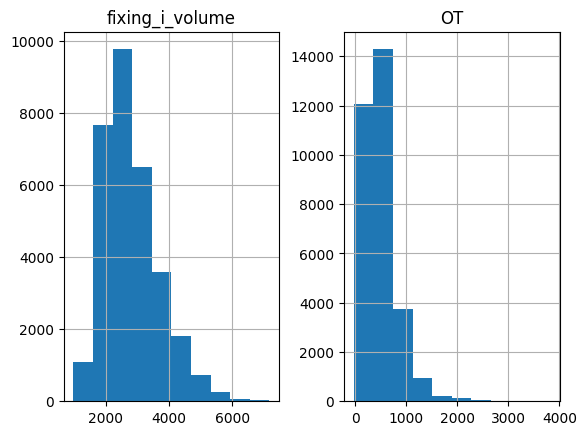

In [24]:
filtered_df.hist()

<Axes: xlabel='date'>

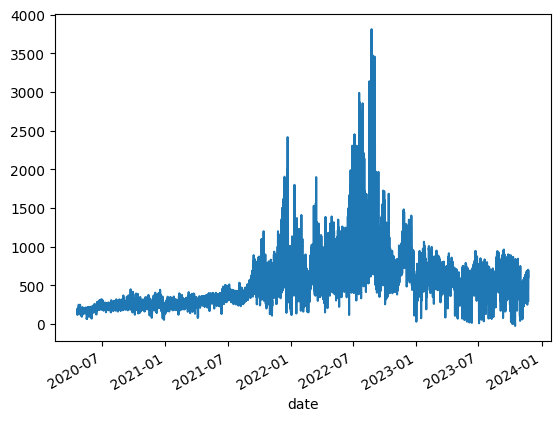

In [13]:
filtered_df["OT"].plot()

<Axes: xlabel='date'>

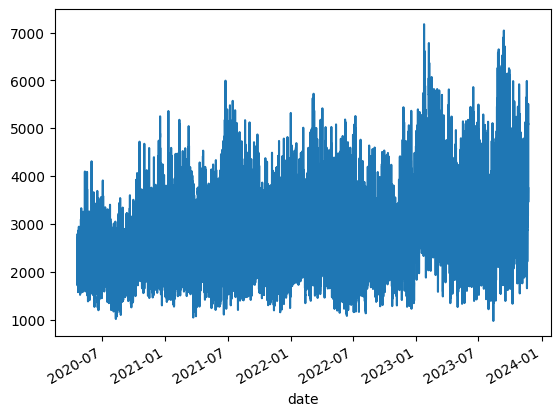

In [14]:
filtered_df["fixing_i_volume"].plot()

Na pierwszym wykresie możemy zauważyć bardzo dynamiczne wahania cen, co może być wynikiem wybuchu wojny na Ukrainie. Aby zminimalować efekt dużych wahań warto zastosować `QuantileScaler` z biblioteki sci-kit learn do przekształcenia danych. Narzędzie to przeskalowuje dane w taki sposób, że kwantyle danych wejściowych są jednostajnie rozłożone w zakresie od 0 do 1. Pozwala to na redukcję wpływu odstających wartości 

In [25]:
from sklearn.preprocessing import QuantileTransformer
import numpy as np

In [26]:
prices = filtered_df['OT'].values.reshape(-1, 1)

In [27]:
quantile_scaler = QuantileTransformer(output_distribution='normal') # normal or uniform
prices_scaled = quantile_scaler.fit_transform(prices)
print(prices)

[[126. ]
 [118. ]
 [118.1]
 ...
 [401.6]
 [384.4]
 [300. ]]


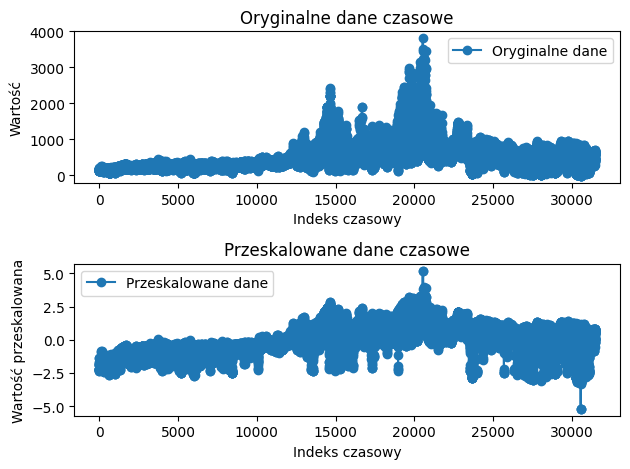

In [28]:
plt.subplot(2, 1, 1)
plt.plot(prices, marker='o', label='Oryginalne dane')
plt.title('Oryginalne dane czasowe')
plt.xlabel('Indeks czasowy')
plt.ylabel('Wartość')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(prices_scaled, marker='o', label='Przeskalowane dane')
plt.title('Przeskalowane dane czasowe')
plt.xlabel('Indeks czasowy')
plt.ylabel('Wartość przeskalowana')
plt.legend()

plt.tight_layout()
plt.show()

Jak widać na wykresach powyżej, transformacja pozwala nam, na zminimalizowaniu niekotrzystnego efektu

Spójrzmy teraz na wykres drugi (tj. fixing_i_volume czyli ilość wytworzonej energii elektrycznej).
Możemy zauważyć naturalny liniowy wzrost, który może wynikać ze zwiększonego zapotrzebowania na energię.
Skorzystamy tutaj z narzędzia jakim jest `MinMaxScaler`. Celem jest przeskalowanie danych w taki sposób aby wartości znajdowały się między 0 a 1.
Robimy to z kilku powodów, m.in.:
 - skalowanie do zakresu 0-1 sprawia, że różne zmienne mają porównywalne skale. Łatwiej jest porównywać wpływ zmiennych na modele statystyczne lub modele uczenia maszynowego.
 - algorytmy uczenia maszynowego stosują metody gradientowe w procesie optymalizacji, często jest tak że przeskalowane dane działają lepiej.

In [29]:
from sklearn.preprocessing import MinMaxScaler

In [36]:
volume = filtered_df['fixing_i_volume'].values.reshape(-1, 1)

min_max_scaler = MinMaxScaler()
volume_scaled = min_max_scaler.fit_transform(volume)

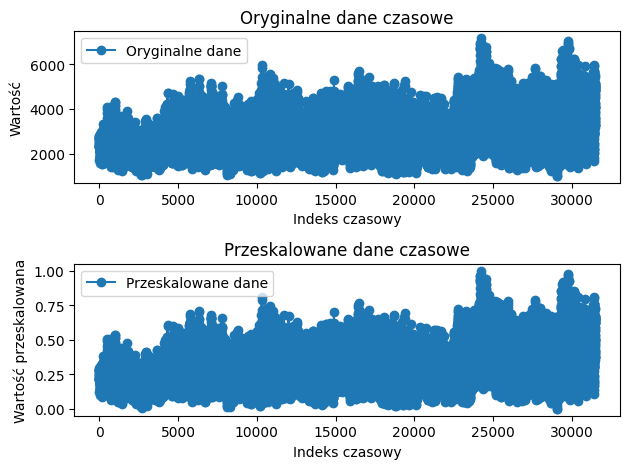

In [37]:
plt.subplot(2, 1, 1)
plt.plot(volume, marker='o', label='Oryginalne dane')
plt.title('Oryginalne dane czasowe')
plt.xlabel('Indeks czasowy')
plt.ylabel('Wartość')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(volume_scaled, marker='o', label='Przeskalowane dane')
plt.title('Przeskalowane dane czasowe')
plt.xlabel('Indeks czasowy')
plt.ylabel('Wartość przeskalowana')
plt.legend()

plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

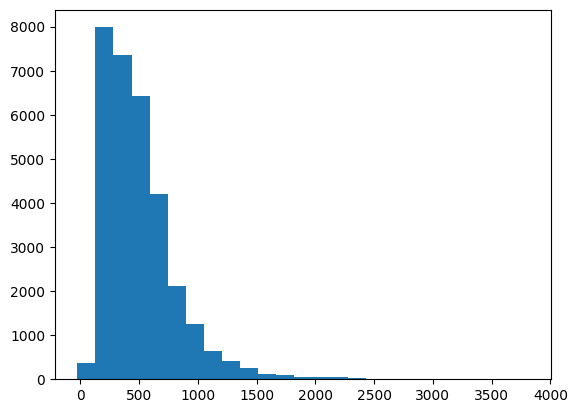

In [32]:
plt.hist(prices, bins=25)
plt.show

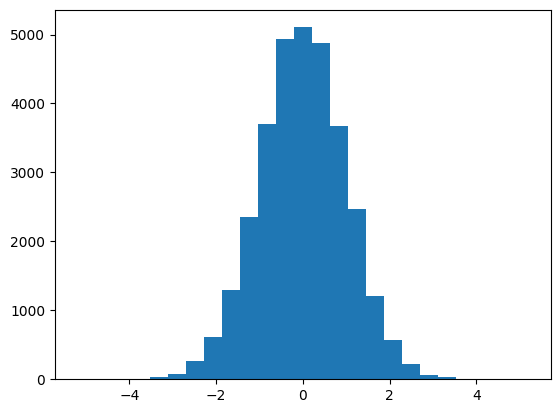

In [33]:
plt.hist(prices_scaled, bins=25)
plt.show()